# List 2

In [ ]:
import imaplib
from pydantic_settings import BaseSettings,SettingsConfigDict
from emails.gmail import  GmailIMAP
from emails.model import  Response
from typing import Any
from functools import lru_cache
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import calendar
import networkx as nx
from utils import with_pickle

In [15]:
class UserAuth(BaseSettings):
    model_config = SettingsConfigDict(frozen=True, env_file=".env", env_prefix="gmail_")
    
    user: str
    password: str
    imap_url: str = "imap.gmail.com"
    
    @property
    def connection(self):
        return imaplib.IMAP4_SSL(self.imap_url) 
    

In [16]:
USER_AUTH = UserAuth()

In [17]:
def get_message_count(manager: GmailIMAP) -> int:
    resp = manager.select("INBOX")
    if not resp.ok:
        raise SystemExit("Cannot open INBOX")
    return resp.message_count

In [18]:
@lru_cache(maxsize=1)
def get_messages(manager: GmailIMAP, count: int = 100, batch_size: int = 20):
    messages = []
    messages_no = min(count, get_message_count(manager))
    fails_coutner = 0
    print(f"Messages to read: {messages_no}.")
    for i in range (1, messages_no + 1, batch_size):
        responses = manager.fetch_messages(range(i, i + batch_size))
        for resp in responses:
            if resp.ok and resp.message:
                messages.append(resp)
            else:
                fails_coutner += 1
    print(f"Successfully read {len(messages)}.")
    print(f"Fails with {fails_coutner}.")
    return messages

# Frequency analysis

In [19]:
def analyze_freq_pattern(manager: GmailIMAP, message_max_limit: int = 100, batch_size: int = 100):
    messages = get_messages(manager, message_max_limit, batch_size)
    dates = pl.DataFrame({"Time": [m.message.date for m in messages]})
    return dates


In [20]:
%%time
MAILS_TO_DOWNLOAD = 1000 
BATCH_SIZE = 100
imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
dates = analyze_freq_pattern(imap, MAILS_TO_DOWNLOAD, BATCH_SIZE)
imap.conn.logout()

Messages to read: 1000.
Successfully read 1000.
Fails with 0.
CPU times: user 985 ms, sys: 209 ms, total: 1.19 s
Wall time: 20.3 s


('BYE', [b'LOGOUT Requested'])

In [21]:
is_written: bool = True
if not is_written: 
    with Path("data/dates.pkl").open("wb") as f:
        pickle.dump(dates, f)
else:
    with Path("data/dates.pkl").open("rb") as f:
        dates = pickle.load(f)

In [22]:
# daily_hist = (
#     dates
#     .with_columns(pl.col("Time").dt.truncate("1d").alias("day"))
#     .group_by("day")
#     .agg(pl.len().alias("count"))
#     .sort("day")
# )

daily_hist = (
    dates
    .sort("Time")
    .group_by_dynamic(
        index_column="Time",
        every="1d",
        closed="left"
    )
    .agg(pl.len().alias("count"))
)

daily_pattern = (
    dates
    .with_columns(pl.col("Time").dt.hour().alias("hour"))
    .group_by("hour")
    .agg(pl.len().alias("count"))
    .sort("hour")
)

monthly_pattern = (
    dates
    .with_columns(pl.col("Time").dt.month().alias("month"))
    .group_by("month")
    .agg(pl.len().alias("count"))
    .sort("month")
)


weekly_pattern = (
    dates
    .with_columns(pl.col("Time").dt.weekday().alias("day"))
    .group_by("day")
    .agg(pl.len().alias("count"))
    .sort("day")
)
daily_pattern
monthly_pattern

month,count
i8,u32
1,122
2,127
3,155
4,96
5,57
…,…
8,7
9,19
10,153


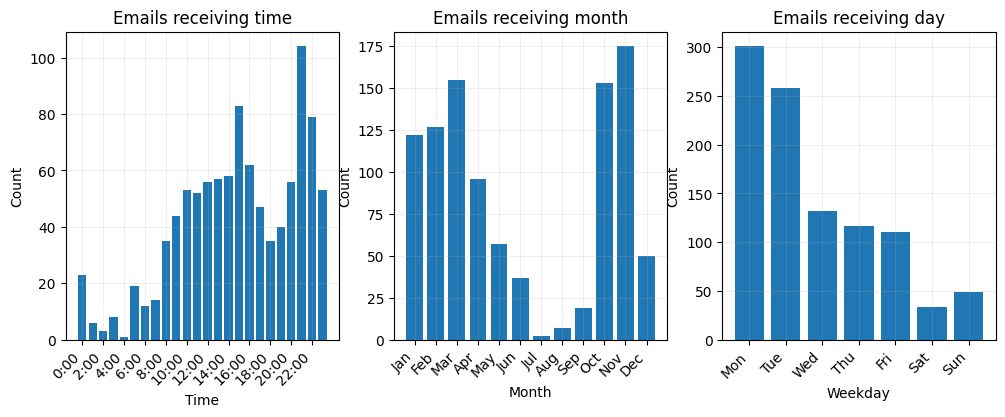

In [23]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
ax = axes.flatten()[0]
ax.bar(daily_pattern["hour"], daily_pattern["count"])
ax.set_xlabel("Time")
ax.set_ylabel("Count")
ax.set_title("Emails receiving time")
ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels((f"{i}:00" for i in range(0, 24, 2)), rotation=45, ha="right")
ax.grid(alpha=0.2)

ax = axes.flatten()[1]
month_names = list(calendar.month_abbr)[1:] # For some reason the first value is an additional empty string
ax.bar(monthly_pattern["month"], monthly_pattern["count"])
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.set_title("Emails receiving month")
ax.set_xticks(range(1,13))
ax.set_xticklabels(month_names, rotation=45, ha="right")
ax.grid(alpha=0.2)


ax = axes.flatten()[2]
weekday_names = list(calendar.day_abbr)
ax.bar(weekly_pattern["day"], weekly_pattern["count"])
ax.set_xlabel("Weekday")
ax.set_ylabel("Count")
ax.set_title("Emails receiving day")
ax.set_xticks(range(1,8))
ax.set_xticklabels(weekday_names, rotation=45, ha="right")
ax.grid(alpha=0.2)


In [24]:
daily_volume = (
    daily_hist
    .group_by("Time")
    .agg(pl.len().alias("count"))
    .with_columns(
        pl.col("count").cum_sum().alias("cumulative_count")
    )
)

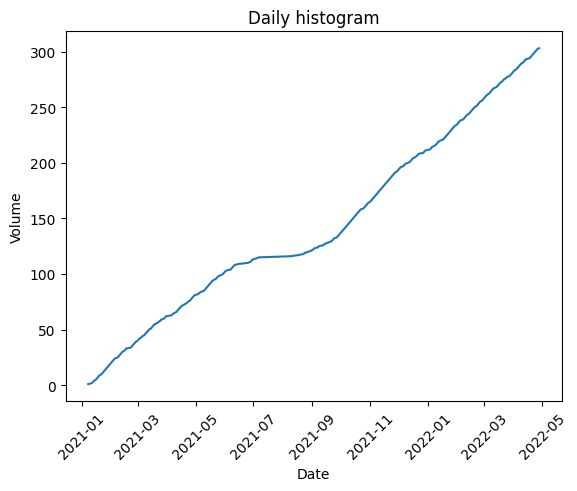

In [25]:

plt.plot(daily_volume["Time"], daily_volume["cumulative_count"])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Daily histogram")
plt.xticks(rotation=45)
plt.show()

# Network graph

In [26]:
def get_message_count(manager: GmailIMAP, dir: str) -> int:
    resp = manager.select(dir)
    if not resp.ok:
        msg = f"Cannot open {dir}"
        raise SystemExit(msg)
    return resp.message_count

@with_pickle()
def get_messages(manager: GmailIMAP, limits: tuple[int] = [80], batch_size: int = 20):
    # dirs = ["INBOX"]
    dirs = ["[Gmail]/Wszystkie"]
    if len(limits) != len(dirs):
        msg = "Limits number must corresponds with number of directories."
        raise ValueError(msg)
    dirs_n_limits = zip(dirs, limits, strict=True)
    messages = []
    fails_coutner = 0
    for d, l in dirs_n_limits:
        print(f"Reading from: {d}")
        messages_no = get_message_count(manager, d)
        print(f"Found {messages_no} in total.")
        messages_no = min(messages_no, l)
        print(f"Messages to read: {messages_no}.")
        manager.select(d)
        for i in range (1, messages_no + 1, batch_size):
            responses = manager.fetch_messages(range(i, i + batch_size))
            for resp in responses:
                if resp.ok and resp.message:
                    messages.append(resp)
                else:
                    fails_coutner += 1
    print(f"Successfully read {len(messages)}.")
    print(f"Fails with {fails_coutner}.")
    return messages

In [41]:
import re
email_regex = re.compile(r" *<([^>]+)> *")
def _get_user(text: str) -> str:
    return re.sub(email_regex, "", text)

from itertools import chain
import hashlib
def _get_hash(text: str) -> str:
    return hashlib.sha1(text.encode("utf-8")).hexdigest()[-6:]
# list(chain.from_iterable([["Ania"], ["Bania", "Hania"]]))

In [141]:

def get_senders(manager: GmailIMAP, *args, **kwargs):
    messages = get_messages(manager, *args, **kwargs)
    return pl.DataFrame({
        "Hash" : [_get_hash(m.message.subject) for m in messages],
        "Date" : [m.message.date for m in messages],
        "Sender": [m.message.sender for m in messages],
        "Sender_count": [len(m.message.sender) for m in messages],
        "Receiver": [m.message.to for m in messages],
        "Receiver_count": [len(m.message.to) for m in messages],
        "CC": [m.message.cc for m in messages],
        "CC_count": [len(m.message.cc) for m in messages],
        "BCC": [m.message.bcc for m in messages],
        "BCC_count": [len(m.message.bcc) for m in messages],
    })

def get_relations(senders: pl.DataFrame) -> pl.DataFrame:
    return (
        senders
        .explode("Sender")
        .explode("Receiver")
        .explode("CC")
        .explode("BCC")
        .with_columns([
            pl.when(pl.col("Receiver").str.contains(r"262290|Jankowski"))
            .then(pl.lit("Me"))
            .otherwise(pl.col("Receiver"))
            .alias("Receiver"),
            
            pl.when(pl.col("Sender").str.contains(r"262290|Jankowski"))
            .then(pl.lit("Me"))
            .otherwise(pl.col("Sender"))
            .alias("Sender"),
        ])
        .filter(
            ~pl.col("Receiver").str.contains(r"wielu adresatów")
        )
        # Remove artifacts
        .filter(
            ~(pl.col("Receiver").str.contains(r"Osobka") & pl.col("Sender").str.contains(r"Osobka"))
        )
        .filter(
            ~(pl.col("Receiver").str.contains(r"test-group") & pl.col("Sender").str.contains(r"botdatabase"))
        )
    )

def create_graph(relations: pl.DataFrame) -> nx.Graph:
    unique_relations = relations.unique([pl.col("Sender"), pl.col("Receiver"), pl.col("CC"), pl.col("BCC")])
    unique_relations = unique_relations.filter(pl.col("Receiver").is_not_null())
    print(f"Unique rows: {len(unique_relations)}")
    edges = list(zip(unique_relations["Sender"], unique_relations["Receiver"]))
    from pyvis.network import Network
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels=False, node_color="lightblue", node_size=15, font_size=12)
    net = Network(
        directed = False,
        select_menu = True,
        filter_menu = True,
    )
    net.show_buttons()
    net.from_nx(G)
    net.save_graph('communicatio_graph.html')
    return G


Unique rows: 2416


('BYE', [b'LOGOUT Requested'])

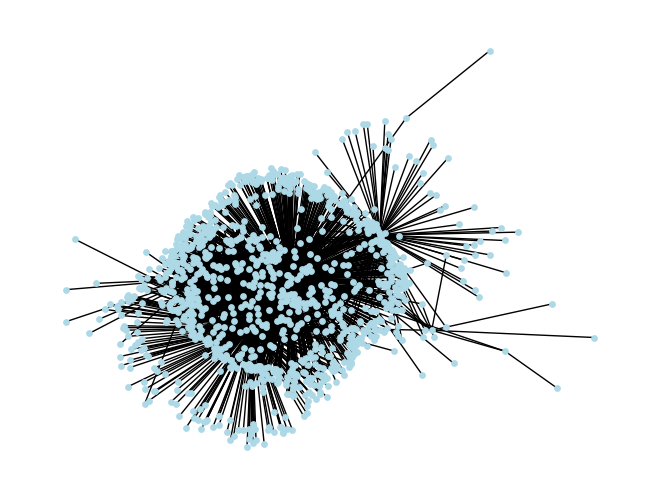

In [142]:
MAILS_TO_DOWNLOAD_COUNT = [6000]
BATCH_SIZE = 200
imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
senders = get_senders(imap, MAILS_TO_DOWNLOAD_COUNT, BATCH_SIZE, pickle_path="data/all_mails.pkl")
relations = get_relations(senders)
relatrions_graph = create_graph(relations)
imap.conn.logout()

In [184]:
def get_g_stats(g: nx.Graph):
    return pl.DataFrame({
        "my_contacts": g.degree["Me"],
        "clustering": nx.average_clustering(g),
        "bc": nx.betweenness_centrality(g)["Me"],
        "radius": nx.radius(g),
        "diameter": nx.diameter(g),
        "top_vs": ",".join([_get_user(k) for k, v in sorted(g.degree(), key=lambda item: item[1], reverse=True)[:3]]),
    })

In [185]:
get_g_stats(relatrions_graph)

my_contacts,clustering,bc,radius,diameter,top_vs
i64,f64,f64,i64,i64,str
564,0.004366,0.822321,3,5,"""Me,Edyta Landkauf,Katarzyna We…"
